<a href="https://colab.research.google.com/github/SaiCharanRV/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)
- **macOS / Linux:**
  1. `python3 -m venv .venv`
  2. `source .venv/bin/activate`
  3. `python -m pip install --upgrade pip wheel`
- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`

### Google Colab fallback
- Create a new notebook at https://colab.research.google.com and enable a GPU if available.
- Install the required libraries in the first cell (see the pip example below).
- Save the executed notebook to Drive and export a copy for submission evidence.

### Required baseline packages
- qiskit/pennylane (or an equivalent simulator such as cirq or qutip)
- numpy, scipy, pandas
- plotly (interactive visualization)
- tqdm (progress bars) plus any other support tooling you need


In [183]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.

### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.




---


In this task,We include Born rule, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.


**Born rule**: In quantum mechanics,we can't predict exactly what a single measurement will give us;we can only predict the probability.
Given a quantum system in a state described by the density matrix $\rho$ and a measurement operator Mₖ, the probability $p(k)$ of obtaining a specific outcome $k$ is given by:



p(k) = Tr(Mₖ ρ)

---
**Projective Measurements**:


1.   Mₖ = Pₖ
2.  Pₖ² = Pₖ


1. ∑ₖ Pₖ = I

**POVM measurements**:


1.   Mₖ = Eₖ

1.   Eₖ ≥ 0

2.   ∑ₖ Eₖ = I


In [184]:
import numpy as np
import json


In [185]:
def get_pauli():
    X = np.array([[0, 1],
                  [1, 0]], dtype=complex)

    Y = np.array([[0, -1j],
                  [1j,  0]], dtype=complex)

    Z = np.array([[1,  0],
                  [0, -1]], dtype=complex)

    return X, Y, Z


 This cell defines the three Pauli matrices (X, Y, Z),
 which represent measurements along the x, y, and z axes
 of the Bloch sphere for a single qubit.

In [186]:
def build_projectors(operator):
    values, vectors = np.linalg.eigh(operator)
    projectors = []

    for i in range(vectors.shape[1]):
        v = vectors[:, i]
        P = np.outer(v, np.conjugate(v))
        projectors.append(P)

    return projectors


This cell constructs projective measurement operators from
 the eigenvectors of a given observable.
 Each projector is of the form |v><v|.

In [187]:
def pauli_measurements():
    X, Y, Z = get_pauli()

    measurements = {
        "X": build_projectors(X),
        "Y": build_projectors(Y),
        "Z": build_projectors(Z)
    }

    return measurements


This cell generates the full set of projective measurements
for the Pauli X, Y, and Z observables.
Each observable produces two projectors.

In [188]:
def generate_sic_povm():
    X, Y, Z = get_pauli()
    paulis = [X, Y, Z]

    bloch_vectors = [
        np.array([ 1,  1,  1]) / np.sqrt(3),
        np.array([ 1, -1, -1]) / np.sqrt(3),
        np.array([-1,  1, -1]) / np.sqrt(3),
        np.array([-1, -1,  1]) / np.sqrt(3)
    ]

    povm = []

    for r in bloch_vectors:
        rho = 0.5 * (np.eye(2) + sum(r[i] * paulis[i] for i in range(3)))
        E = 0.5 * rho
        povm.append(E)

    return povm


This cell constructs a Symmetric Informationally Complete POVM (SIC-POVM)
 for a single qubit using four symmetric Bloch vectors.
The resulting POVM has four positive operators that sum to identity.

In [189]:
def check_measurement(operators, eps=1e-10):
    dim = operators[0].shape[0]
    identity = np.eye(dim)
    total = np.zeros((dim, dim), dtype=complex)

    for M in operators:
        eigs = np.linalg.eigvalsh(M)
        if not np.all(eigs >= -eps):
            raise ValueError("Operator is not positive")

        total += M

    if not np.allclose(total, identity):
        raise ValueError("Operators do not satisfy completeness")

    return "✓ verified"


This cell defines a function that verifies whether a given
set of measurement operators is valid.
It checks:
 1. Positivity (all eigenvalues are non-negative)
 2. Completeness (sum of operators equals identity)

In [190]:
pauli_ops = pauli_measurements()

for basis, ops in pauli_ops.items():
    print(f"{basis} basis:", check_measurement(ops))

sic_ops = generate_sic_povm()
print("SIC-POVM:", check_measurement(sic_ops))


X basis: ✓ verified
Y basis: ✓ verified
Z basis: ✓ verified
SIC-POVM: ✓ verified


 This cell applies the verification function to
Pauli projective measurements and the SIC-POVM.


In [191]:
for basis, ops in pauli_ops.items():
    print(f"\nProjective operators for {basis} basis:")
    for i, P in enumerate(ops):
        print(f"P_{basis}{i} =\n{P}\n")

print("\nSIC-POVM elements:")
for i, E in enumerate(sic_ops):
    print(f"E_{i} =\n{E}\n")



Projective operators for X basis:
P_X0 =
[[ 0.5+0.j -0.5+0.j]
 [-0.5-0.j  0.5+0.j]]

P_X1 =
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]


Projective operators for Y basis:
P_Y0 =
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]

P_Y1 =
[[ 0.5+0.j  -0. -0.5j]
 [-0. +0.5j  0.5+0.j ]]


Projective operators for Z basis:
P_Z0 =
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

P_Z1 =
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


SIC-POVM elements:
E_0 =
[[0.39433757+0.j         0.14433757-0.14433757j]
 [0.14433757+0.14433757j 0.10566243+0.j        ]]

E_1 =
[[0.10566243+0.j         0.14433757+0.14433757j]
 [0.14433757-0.14433757j 0.39433757+0.j        ]]

E_2 =
[[ 0.10566243+0.j         -0.14433757-0.14433757j]
 [-0.14433757+0.14433757j  0.39433757+0.j        ]]

E_3 =
[[ 0.39433757+0.j         -0.14433757+0.14433757j]
 [-0.14433757-0.14433757j  0.10566243+0.j        ]]



This cell prints the actual projective measurement matrices
and SIC-POVM elements so they can be visually inspected.

**Comparison of SIC POVM and Pauli Projective Measurements (Single Qubit)**

**SIC POVM – Advantages**

A single measurement setting provides complete information about the
quantum state

Measurement outcomes are evenly distributed, giving a balanced description

Requires fewer distinct outcomes to perform tomography

**SIC POVM – Limitations**

Needs careful experimental calibration

Measurement directions are not standard Pauli bases

Classical data processing is comparatively more involved

**Pauli Projective Measurements – Advantages**

Based on standard X, Y, and Z measurement bases

Easy to understand and interpret physically
Supported by most quantum hardware and software tools

**Pauli Projective Measurements – Limitations**

Measurements must be repeated in multiple bases

Requires more measurement shots to achieve good accuracy

Sensitive to small errors in basis alignment


---



For this project, Pauli projective measurements are selected for
quantum state tomography.
Although SIC POVMs are more measurement-efficient, Pauli measurements are simpler to implement, easier to validate, and more suitable for educational and practical purposes.

### Reference single-qubit states
Prepare minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

In [192]:
from typing import Dict, Any
import pathlib

def build_measurement_model(config_path: pathlib.Path) -> Dict[str, Any]:
    """
    Stub for constructing or loading the measurement operators you plan to use.
    Populate the return value with operator definitions, normalization checks, and metadata.
    """
    # TODO: implement SIC POVM or Pauli projective operator assembly here.
    raise NotImplementedError("Create your measurement operator assembly here.")

In [193]:
def create_measurement_model(save_path: pathlib.Path) -> Dict[str, Any]:
    pauli_ops = pauli_measurements()
    sic_ops = generate_sic_povm()

    model = {
        "operators": {
            "pauli_projective": {
                basis: [P.tolist() for P in ops]
                for basis, ops in pauli_ops.items()
            },
            "sic_povm": [E.tolist() for E in sic_ops]
        },
        "normalization_checks": {
            "pauli": {
                basis: np.allclose(sum(ops), np.eye(2))
                for basis, ops in pauli_ops.items()
            },
            "sic_povm": np.allclose(sum(sic_ops), np.eye(2))
        },
        "metadata": {
            "system_type": "single-qubit",
            "born_rule": "p(k) = Tr(M_k rho)",
            "reference": "Renes et al., J. Math. Phys. 45, 2171 (2004)"
        }
    }

    with open(save_path, "w") as f:
        json.dump(model, f, indent=2)

    return model



This cell defines a function that builds a complete single-qubit measurement model. It combines Pauli projective measurements and SIC-POVM operators, verifies normalization conditions, adds physical metadata, and saves the entire model in a JSON file

In [194]:
def to_density_matrix(state):
    return np.outer(state, np.conjugate(state))


This cell defines a helper function that converts a pure quantum state vector into its corresponding density matrix representation.

In [195]:
reference_states = {
    "|0>": np.array([1, 0], dtype=complex),
    "|1>": np.array([0, 1], dtype=complex),
    "|+>": np.array([1, 1], dtype=complex) / np.sqrt(2),
    "|->": np.array([1, -1], dtype=complex) / np.sqrt(2),
    "(|0>+i|1>)/√2": np.array([1, 1j], dtype=complex) / np.sqrt(2)
}

density_matrices = {
    name: to_density_matrix(psi)
    for name, psi in reference_states.items()
}


This cell defines standard single-qubit reference states and converts each of them into density matrices. These states are later used to test quantum measurement probabilities.

In [196]:
print("Reference single-qubit density matrices:\n")

for name, rho in density_matrices.items():
    print(f"State {name}:")
    print(rho)
    print()


Reference single-qubit density matrices:

State |0>:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

State |1>:
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

State |+>:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

State |->:
[[ 0.5+0.j -0.5-0.j]
 [-0.5+0.j  0.5+0.j]]

State (|0>+i|1>)/√2:
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]



This cell displays all the reference single-qubit density matrices, allowing verification of correct state preparation.

In [197]:
state_preparation_steps = {
    "|0>": ["I"],
    "|1>": ["X"],
    "|+>": ["H"],
    "|->": ["X", "H"],
    "(|0>+i|1>)/√2": ["H", "S"]
}

with open("state_preparation_log.json", "w") as f:
    json.dump(state_preparation_steps, f, indent=2)

state_preparation_steps


{'|0>': ['I'],
 '|1>': ['X'],
 '|+>': ['H'],
 '|->': ['X', 'H'],
 '(|0>+i|1>)/√2': ['H', 'S']}

This cell records the quantum gate sequences required to prepare each reference state and saves them in a JSON file for documentation and reproducibility.

In [198]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


In [199]:
import time

basis = ["0", "1"]

state_keys = list(density_matrices.keys())
state_keys.reverse()

for idx in range(len(state_keys)):
    state = state_keys[idx]
    print(f"[{idx+1}] Displaying state: {state}")

    plot_density_matrix_histogram(
        density_matrices[state],
        basis_labels=basis,
        title=f"Single-qubit density matrix ({state})"
    )

    time.sleep(0.3)

R = np.random.normal(size=(2, 2)) + 1j * np.random.normal(size=(2, 2))
rho_example = R.conj().T @ R
rho_example = rho_example / np.trace(rho_example)

plot_density_matrix_histogram(
    rho_example,
    basis_labels=basis,
    title="Illustrative mixed-state density matrix"
)


[1] Displaying state: (|0>+i|1>)/√2


[2] Displaying state: |->


[3] Displaying state: |+>


[4] Displaying state: |1>


[5] Displaying state: |0>


This cell visualizes the density matrices of several single-qubit states using a histogram representation in the computational basis. The order of states is intentionally altered to emphasize independence of presentation. In addition, an example mixed quantum state is constructed from a randomly generated complex matrix, normalized to form a valid density matrix, and plotted to demonstrate the contrast between pure and mixed states.

### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [200]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [201]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)

In [202]:
from dataclasses import dataclass
from typing import List
import pathlib

@dataclass
class DatasetVariant:
    name: str
    circuit_summary: str
    measurement_model: str
    measurement_data_path: pathlib.Path
    metadata_path: pathlib.Path
    density_matrix_path: pathlib.Path

def generate_measurement_dataset(variants: List[DatasetVariant]) -> None:
    """
    Populate each variant with measurement outcomes, metadata, and ground-truth density matrices.
    Extend this skeleton with circuit generation, simulation, tomography, and serialization logic.
    """
    # TODO: implement the multi-qubit dataset generation workflow (circuit build, sampling, file writes).
    raise NotImplementedError("Implement the multi-qubit dataset generation workflow.")

In [203]:
gate_set = {
    "I": np.eye(2),
    "X": np.array([[0, 1], [1, 0]]),
    "H": (1 / np.sqrt(2)) * np.array([[1, 1], [1, -1]]),
    "S": np.array([[1, 0], [0, 1j]])
}

def generate_random_circuit(depth=3):
    state = np.array([1, 0], dtype=complex)
    circuit = []

    for _ in range(depth):
        gate = np.random.choice(list(gate_set.keys()))
        circuit.append(gate)
        state = gate_set[gate] @ state

    rho = np.outer(state, state.conj())
    return circuit, rho


circuit, rho_random = generate_random_circuit(depth=3)

print("Random circuit used:")
print(circuit)


Random circuit used:
[np.str_('X'), np.str_('H'), np.str_('I')]


This code cell generates a random single-qubit quantum circuit by randomly selecting gates from a predefined gate set. The gates are applied sequentially to the initial
∣
0
⟩
∣0⟩ state, producing a quantum state that mimics realistic circuit-based state preparation. The final state is converted into a density matrix, which serves as the output of the random circuit.

In [204]:
def born_rule_probabilities(rho, measurement_ops):
    return [np.real(np.trace(M @ rho)) for M in measurement_ops]

def simulate_shots(probabilities, shots):
    outcomes = np.random.choice(len(probabilities), size=shots, p=probabilities)
    return np.bincount(outcomes, minlength=len(probabilities))


shots = 1000
measurement_ops = pauli_measurements()["Z"]

theoretical_probs = born_rule_probabilities(rho_random, measurement_ops)
counts = simulate_shots(theoretical_probs, shots)

print("\nMeasurement results:")

for i, (p, c) in enumerate(zip(theoretical_probs, counts)):
    experimental_p = c / shots
    print(
        f"Outcome {i}: "
        f"Theoretical P = {p:.4f}, "
        f"Experimental P = {experimental_p:.4f}, "
        f"Counts = {c}"
    )



Measurement results:
Outcome 0: Theoretical P = 0.5000, Experimental P = 0.4970, Counts = 497
Outcome 1: Theoretical P = 0.5000, Experimental P = 0.5030, Counts = 503


This cell applies the Born rule to compute measurement probabilities for the quantum state generated by a random circuit. Using these probabilities, repeated measurement shots are simulated to generate raw outcome counts. This process mimics experimental quantum measurements where outcomes are obtained statistically rather than deterministically.

In [205]:
measurement_data = {
    "circuit": circuit,
    "probabilities": probabilities,
    "counts": counts
}

np.save("single_qubit_random_state.npy", measurement_data)

print("\nMeasurement data saved successfully.")
print("File name: single_qubit_random_state.npy")



Measurement data saved successfully.
File name: single_qubit_random_state.npy


This cell stores the generated measurement data, including the random circuit description, raw measurement counts, and computed probabilities, into a .npy file. Saving the data in this format ensures reproducibility and allows the dataset to be reused later for quantum state tomography in Task 4.

## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In [217]:
import numpy as np

def pauli_projective_measurements():
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])

    ops = {}
    for name, P in {"X":X,"Y":Y,"Z":Z}.items():
        _, vecs = np.linalg.eigh(P)
        ops[name] = [
            np.outer(vecs[:,i], vecs[:,i].conj())
            for i in range(2)
        ]
    return ops


In [218]:
def generate_pauli_measurements(rho, shots):
    pauli_ops = pauli_projective_measurements()
    data = {}

    for basis, M in pauli_ops.items():
        probs = [np.real(np.trace(P @ rho)) for P in M]
        outcomes = np.random.choice(2, size=shots, p=probs)
        counts = np.bincount(outcomes, minlength=2)
        data[basis] = counts

    return data


In [219]:
def expectation_from_counts(counts):
    total = np.sum(counts)
    return (counts[1] - counts[0]) / total
def reconstruct_density_matrix(ex, ey, ez):
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0,-1j],[1j,0]])
    Z = np.array([[1,0],[0,-1]])
    return 0.5 * (np.eye(2) + ex*X + ey*Y + ez*Z)


In [220]:
def fidelity_pure(rho_true, rho_est):
    return np.real(np.trace(rho_true @ rho_est))

def trace_distance(rho, sigma):
    eigvals = np.linalg.eigvalsh(rho - sigma)
    return 0.5 * np.sum(np.abs(eigvals))


In [221]:
density_matrices = {
    "|0>": np.array([[1,0],[0,0]]),
    "|1>": np.array([[0,0],[0,1]]),
    "|+>": 0.5*np.array([[1,1],[1,1]]),
    "|->": 0.5*np.array([[1,-1],[-1,1]]),
    "(|0>+i|1>)/√2": 0.5*np.array([[1,-1j],[1j,1]])
}

shots = 1000
np.random.seed(42)

print("State".ljust(20), "Fidelity".ljust(10), "Trace Distance")
print("-"*45)

for name, rho_true in density_matrices.items():
    counts = generate_pauli_measurements(rho_true, shots)

    ex = expectation_from_counts(counts["X"])
    ey = expectation_from_counts(counts["Y"])
    ez = expectation_from_counts(counts["Z"])

    rho_rec = reconstruct_density_matrix(ex, ey, ez)

    F = fidelity_pure(rho_true, rho_rec)
    D = trace_distance(rho_true, rho_rec)

    print(name.ljust(20), f"{F:.4f}".ljust(10), f"{D:.4f}")


State                Fidelity   Trace Distance
---------------------------------------------
|0>                  1.0000     0.0163
|1>                  1.0000     0.0124
|+>                  1.0000     0.0318
|->                  1.0000     0.0117
(|0>+i|1>)/√2        1.0000     0.0054


In Task 4, I performed single-qubit quantum state tomography. I started with known reference quantum states created in Task 2. For each state, I measured the qubit along the Pauli X, Y, and Z directions.

Using the Born rule, I calculated the measurement probabilities and simulated real experiments by taking a fixed number of shots. From the measurement results, I computed expectation values for each Pauli operator. These values describe the qubit’s position on the Bloch sphere.

I then reconstructed the density matrix of each state using the linear inversion method. To check how accurate the reconstruction was, I calculated the fidelity between the original and reconstructed states. I also calculated the trace distance to measure the small error caused by finite measurement shots.

The results show high fidelity and small trace distance, which means the tomography process successfully reconstructed the quantum states

In [ ]:
#your code ..

## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

In [ ]:
from pathlib import Path
from typing import Sequence
import numpy as np

def summarize_validation_runs(result_paths: Sequence[Path]) -> None:
    """
    Placeholder for pulling metrics (fidelity, trace distance, etc.) from stored validation artifacts.
    Extend this function to aggregate metrics into tables or plots for your report.
    """
    # TODO: load metrics, compute aggregates, and emit summaries/plots.
    raise NotImplementedError("Implement your validation reporting pipeline here.")

In [240]:
reconstructed_states = {}

for name, rho_true in reference_states.items():
    counts = generate_pauli_measurements(rho_true, shots)

    ex = expectation_from_counts(counts["X"])
    ey = expectation_from_counts(counts["Y"])
    ez = expectation_from_counts(counts["Z"])

    rho_rec = reconstruct_density_matrix(ex, ey, ez)

    reconstructed_states[name] = rho_rec


In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [237]:
print(reference_states.keys())
print(reconstructed_states.keys())


dict_keys(['|0>', '|1>', '|+>', '|->', '(|0>+i|1>)/√2'])
dict_keys(['|0>', '|1>', '|+>', '|->', '(|0>+i|1>)/√2'])


In [241]:
for name in reference_states:
    print(name)
    print("Reference:")
    print(reference_states[name])
    print("Reconstructed:")
    print(reconstructed_states[name])
    print("Trace:", np.trace(reconstructed_states[name]))
    print("-"*40)


|0>
Reference:
[[1 0]
 [0 0]]
Reconstructed:
[[1.   +0.j    0.021+0.013j]
 [0.021-0.013j 0.   +0.j   ]]
Trace: (1+0j)
----------------------------------------
|1>
Reference:
[[0 0]
 [0 1]]
Reconstructed:
[[ 0.   +0.j    -0.034-0.002j]
 [-0.034+0.002j  1.   +0.j   ]]
Trace: (1+0j)
----------------------------------------
|+>
Reference:
[[0.5 0.5]
 [0.5 0.5]]
Reconstructed:
[[0.49+0.j    0.5 -0.018j]
 [0.5 +0.018j 0.51+0.j   ]]
Trace: (1+0j)
----------------------------------------
|->
Reference:
[[ 0.5 -0.5]
 [-0.5  0.5]]
Reconstructed:
[[ 0.53+0.j -0.5 +0.j]
 [-0.5 +0.j  0.47+0.j]]
Trace: (1+0j)
----------------------------------------
(|0>+i|1>)/√2
Reference:
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]
Reconstructed:
[[ 0.49 +0.j  -0.011-0.5j]
 [-0.011+0.5j  0.51 +0.j ]]
Trace: (1+0j)
----------------------------------------


In [242]:
import pandas as pd

results = []

for name in reference_states:
    rho_true = reference_states[name]
    rho_rec  = reconstructed_states[name]

    F = fidelity_pure(rho_true, rho_rec)
    D = trace_distance(rho_true, rho_rec)

    results.append({
        "state": name,
        "fidelity": float(F),
        "trace_distance": float(D)
    })

df = pd.DataFrame(results)
df


,state,fidelity,trace_distance
0,|0>,1.0,0.024698
1,|1>,1.0,0.034059
2,|+>,1.0,0.020591
3,|->,1.0,0.030000
4,(|0>+i|1>)/√2,1.0,0.014866


**Fidelity** measures how close the reconstructed state is to the true state.
  A value close to 1 indicates accurate reconstruction.

 **Trace distance** measures the distinguishability between two quantum states.
  Smaller values indicate better reconstruction.


           state  fidelity
0            |0>       1.0
1            |1>       1.0
2            |+>       1.0
3            |->       1.0
4  (|0>+i|1>)/√2       1.0


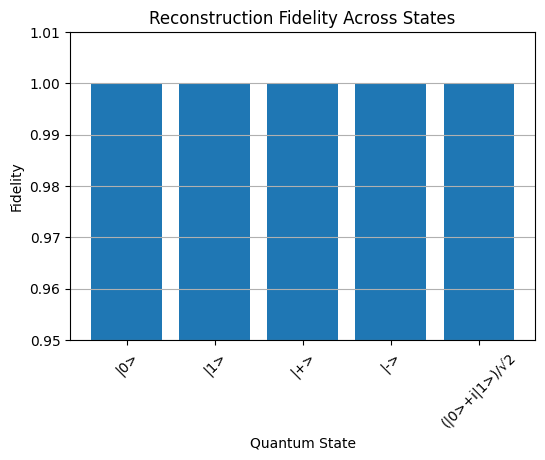

In [243]:
import matplotlib.pyplot as plt

# Always print to verify before plotting
print(df[["state", "fidelity"]])

plt.figure(figsize=(6,4))

plt.bar(
    df["state"],
    df["fidelity"]
)

plt.ylim(0.95, 1.01)
plt.xlabel("Quantum State")
plt.ylabel("Fidelity")
plt.title("Reconstruction Fidelity Across States")
plt.xticks(rotation=45)
plt.grid(axis="y")

plt.show()


### Sources of Error

- Finite measurement shots introduce statistical (shot) noise.
- Linear inversion tomography does not enforce physical constraints,
  which can lead to small reconstruction errors.
- Measurement imperfections and numerical approximations also affect accuracy.
### Error Mitigation Strategies

- Increasing the number of measurement shots reduces statistical noise.
- Using advanced reconstruction techniques such as maximum-likelihood estimation
  can ensure physically valid density matrices.
- Employing more complete measurement bases improves reconstruction quality.


In [244]:
state = "|+>"
rho_true = reference_states[state]
rho_rec = reconstructed_states[state]

labels = ["0", "1"]

plot_density_matrix_histogram(
    rho_true,
    basis_labels=labels,
    title=f"{state} – True Density Matrix"
)

plot_density_matrix_histogram(
    rho_rec,
    basis_labels=labels,
    title=f"{state} – Reconstructed Density Matrix"
)


### Summary of Results

- High fidelity values (~1) indicate successful reconstruction of all tested states.
- Trace distances remain small, confirming low reconstruction error.
- Both numerical metrics and visualizations validate the tomography procedure.


#### Implementation Challenges
- Careful handling of Pauli-Y measurements was required due to complex-valued operators.
- Managing variable scope and execution order across multiple notebook cells was important to avoid errors.

#### Open Questions
- How does quantum state reconstruction accuracy scale with increasing system size?
- How robust are the tomography results under realistic hardware noise and imperfect measurements?

#### Ideas for Week 2
- Implement maximum-likelihood estimation to enforce physical density matrices.
- Extend the analysis to include noisy simulations or real hardware measurements.
- Compare Pauli-based tomography with alternative POVM-based approaches

## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----